Imports

In [1]:
# Libraries
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import importlib
import src # Random seed set here
importlib.reload(src)

2024-12-09 19:40:30.144072: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.
Python random seed set.
NumPy random seed set.
TensorFlow (Keras) random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Data setup

In [2]:
# Path setup
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data', 'raw')
output_dir = os.path.join(root_dir, 'out')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Folder '{output_dir}' was created.")
else:
    print(f"Folder '{output_dir}' already exists.")

# Data loading
csv_files = glob.glob(os.path.join(data_dir, 'wind_speed_*.csv'))
dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

Folder '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/out' already exists.


Data setup - delayed time features generator

In [3]:
def create_time_delayed_features_optimized(df, input_features, time_steps=3):
    """
    Create time-delayed features for a given DataFrame using vectorized operations.

    Args:
    - df: The DataFrame containing the scaled data.
    - input_features: The list of input feature names.
    - time_steps: The number of previous time steps to include (default is 3).

    Returns:
    - A DataFrame with time-delayed features.
    """
    delayed_df = pd.DataFrame(index=df.index)
    new_input_features = []
    for feature in input_features:
        for t in range(time_steps + 1):
            delayed_df[f"{feature}_t-{t}"] = df[feature].shift(t)
            new_input_features.append(f"{feature}_t-{t}")
    delayed_df.dropna(inplace=True)
    return delayed_df, new_input_features

Data setup - Parameters and splitting

In [4]:
# Features and parameters
input_features = ['beta1', 'beta2', 'beta3', 'Theta', 'omega_r', 'Vwx']
output_features = ['Mz1', 'Mz2', 'Mz3']
num_center = 15
sigma = 0.7
time_steps = 2
lstm_units = 50

# Split data into train, validation, and test sets
train_val_data, test_data = train_test_split(combined_df, test_size=0.2, random_state=42, shuffle=False)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on training data
X_train = scaler_X.fit_transform(train_data[input_features])
y_train = scaler_y.fit_transform(train_data[output_features])
X_val = scaler_X.transform(val_data[input_features])
y_val = scaler_y.transform(val_data[output_features])
X_test = scaler_X.transform(test_data[input_features])
y_test = scaler_y.transform(test_data[output_features])

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Model setup

In [5]:
# Custom RBF Layer
class RBFLayer(Layer):
    def __init__(self, num_centers, sigma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.num_centers = num_centers
        self.sigma = sigma

    def build(self, input_shape):
        self.centers = self.add_weight(
            shape=(self.num_centers, input_shape[-1]),
            initializer="random_normal",
            trainable=True,
            name="centers"
        )

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, 1)
        centers_expanded = tf.expand_dims(self.centers, 0)
        distances = tf.reduce_sum(tf.square(inputs_expanded - centers_expanded), axis=-1)
        return tf.exp(-distances / (2 * tf.square(self.sigma)))


# LSTM-RBF model without L2 regularization
def build_lstm_rbf_model(input_dim, num_centers, sigma, lstm_units, output_dim):
    model = Sequential([
        Input(shape=(None, input_dim)),  # Sequential data
        RBFLayer(num_centers=num_centers, sigma=sigma),  # RBF layer
        LSTM(lstm_units,
             activation='tanh',
             return_sequences=False),  # LSTM layer without L2 regularization
        Dense(output_dim)  # Output layer without L2 regularization
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

Build and train model

In [6]:
# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor val_loss
    min_delta=0.0001,           # Minimum improvement to consider
    patience=10,                # Number of epochs to wait before stopping
    verbose=1,                  # Print when early stopping is triggered
    restore_best_weights=True   # Restore the best weights after stopping
)

# Build the model
model = build_lstm_rbf_model(
    input_dim=X_train.shape[-1],
    num_centers=num_center,
    sigma=sigma,
    lstm_units=lstm_units,
    output_dim=y_train.shape[-1]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,                 # Set to a higher maximum epoch value
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]  # Include the Early Stopping callback
)

# Save training history
history_path = os.path.join(output_dir, 'final_no_l2.json')
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"Training history saved to '{history_path}'")

Epoch 1/100
32001/32001 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0063 - mae: 0.0580 - val_loss: 0.0032 - val_mae: 0.0437
Epoch 2/100
32001/32001 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0032 - mae: 0.0433 - val_loss: 0.0031 - val_mae: 0.0429
Epoch 3/100
25761/32001 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0031 - mae: 0.0430

KeyboardInterrupt: 

Evaluate model

In [7]:
# Evaluate on test set
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=1)

# Denormalize predictions and ground truth
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)
y_test = scaler_y.inverse_transform(y_test)

# Print test results
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Save test results
test_results_df = pd.DataFrame({
    't': test_data['t'].values,  # Assuming 't' is the time column
    'y_test_Mz1': y_test[:, 0],
    'y_pred_Mz1': y_test_pred[:, 0],
    'y_test_Mz2': y_test[:, 1],
    'y_pred_Mz2': y_test_pred[:, 1],
    'y_test_Mz3': y_test[:, 2],
    'y_pred_Mz3': y_test_pred[:, 2]
})

test_results_path = os.path.join(output_dir, 'final_no_l2.csv')
test_results_df.to_csv(test_results_path, index=False)
print(f"Test results saved to '{test_results_path}'")

10001/10001 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0036 - mae: 0.0457
10001/10001 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Test MSE: 0.003626410383731127
Test MAE: 0.045984894037246704
Test results saved to '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/out/final_no_l2.csv'


In [8]:
print(test_results_df["y_pred_Mz1"].to_numpy())
print(test_results_df["y_test_Mz1"])
# print(y_)


[-55.550346 -55.25529  -55.273018 ... -30.492325 -29.459545 -30.290478]
0        -26.835749
1        -26.410484
2        -26.289404
3        -26.197079
4        -26.416470
            ...    
319996   -56.638138
319997   -55.432899
319998   -55.254314
319999   -55.207016
320000   -55.075851
Name: y_test_Mz1, Length: 320001, dtype: float64


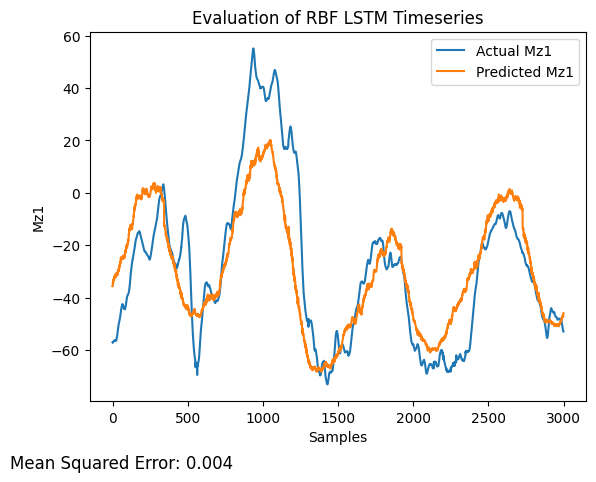

In [13]:
start=1000
src.plots.evaluate_predictions(test_results_df["y_pred_Mz1"].to_numpy()[start:start+3000], test_results_df["y_test_Mz1"].to_numpy()[start:start+3000], 0.004, name=f"RBF LSTM Timeseries")